In [1]:
pip install crewai 'crewai[tools]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.8 MB/s eta

In [2]:
import os
from os import environ
from google.colab import userdata
google_api=userdata.get('gemini_flow')
os.environ['OPENAI_API_KEY'] = google_api

In [4]:
import getpass
import time
initial_time = time.time()

In [3]:
from crewai import LLM

llm = LLM(
    model="gemini/gemini-2.0-flash-lite",
    temperature=0.2,
    api_key=google_api,
)

In [14]:
from crewai.flow.flow import Flow, start, listen, router, or_
from pydantic import BaseModel
import random
from crewai import LLM

In [13]:
llm.call("what is is ?")

'"Is" is a form of the verb "to be." It\'s used in the present tense and is the third-person singular form (used with "he," "she," "it," or a singular noun).\n\nHere are some examples of how "is" is used:\n\n*   **He is** happy.\n*   **She is** a doctor.\n*   **It is** raining.\n*   The cat **is** sleeping.\n\n"Is" can also be used as a helping verb (also called an auxiliary verb) to form continuous tenses and passive voice:\n\n*   **He is** running. (present continuous)\n*   The book **is** being read. (present passive)\n\nSo, the meaning of "is" depends on the context, but it generally indicates existence, a state of being, or an action in the present time.\n'

In [15]:
# Define a structured state for our flow
class ContentState(BaseModel):
    topic: str = ""
    research_notes: str = ""
    draft: str = ""
    final_article: str = ""
    revision_count: int = 0
    quality: str = ""

In [30]:
class ComplexContentFlow(Flow[ContentState]):
    model = llm

    @start()
    def get_topic(self):
        """
        Start by selecting a topic.
        """
        self.state.topic = "AI in Healthcare"  #topic
        print(f"Topic selected: {self.state.topic}")
        return self.state.topic

    @listen(get_topic)
    def conduct_research(self, topic):
        """
        Conduct research using Gemini.
        """
        prompt = f"Provide a brief research summary on {self.state.topic}."
        research_notes = llm.call(prompt)
        self.state.research_notes = research_notes  #research_notes
        print(f"Research completed: {research_notes}")
        return research_notes

    @listen(conduct_research)
    def write_draft(self, research_notes):
        """
        Generate a draft article.
        """
        prompt = f"Write a well-structured article on {self.state.topic} based on the following research: {research_notes}"
        draft = llm.call(prompt)
        self.state.draft = draft  # draft
        self.state.revision_count += 1  #revison count
        print(f"Draft written: {draft}")
        return draft

    @router(write_draft)
    def select_editing_path(self):
        """
        Choose an editing path based on a simulated quality score.
        """
        quality_score = random.randint(1, 100)
        self.state.quality = "high" if quality_score > 70 else "low"   # quality
        print(f"Draft quality score: {quality_score}, assigned quality: {self.state.quality}")
        if self.state.quality == "high":
            return "light_edit"
        else:
            return "heavy_edit"

    @listen("light_edit")
    def light_editing(self):
        """
        Apply light editing to the draft.
        """
        prompt = f"Lightly edit the following draft to improve readability: {self.state.draft}"
        edited = llm.call(prompt)
        print(f"Light editing applied: {edited}")
        return edited

    @listen("heavy_edit")
    def heavy_editing(self):
        """
        Apply heavy editing to the draft.
        """
        prompt = f"Rewrite the following draft with significant improvements in structure and clarity: {self.state.draft}"
        edited = llm.call(prompt)
        print(f"Heavy editing applied: {edited}")
        return edited

    @listen(or_(light_editing, heavy_editing)) # light_editing or heavy_editing
    def compile_article(self, edited_draft):
        """
        Compile the final article.
        """
        final = f"Final article: {edited_draft}"
        self.state.final_article = final ## final_article
        print(f"Article compiled: {final}")
        return final


In [23]:
flow=ComplexContentFlow()
flow.plot()


╭──────────────────────────────────────────────── Flow Execution ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Starting Flow Execution                                                                                        │
│  Name: ComplexContentFlow                                                                                       │
│  ID: 573831bf-836a-4f33-9cc5-900c9f4203f9                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Plot saved as crewai_flow.html


In [26]:
from IPython.display import IFrame

IFrame(src='/content/crewai_flow.html', width='150%', height=600)

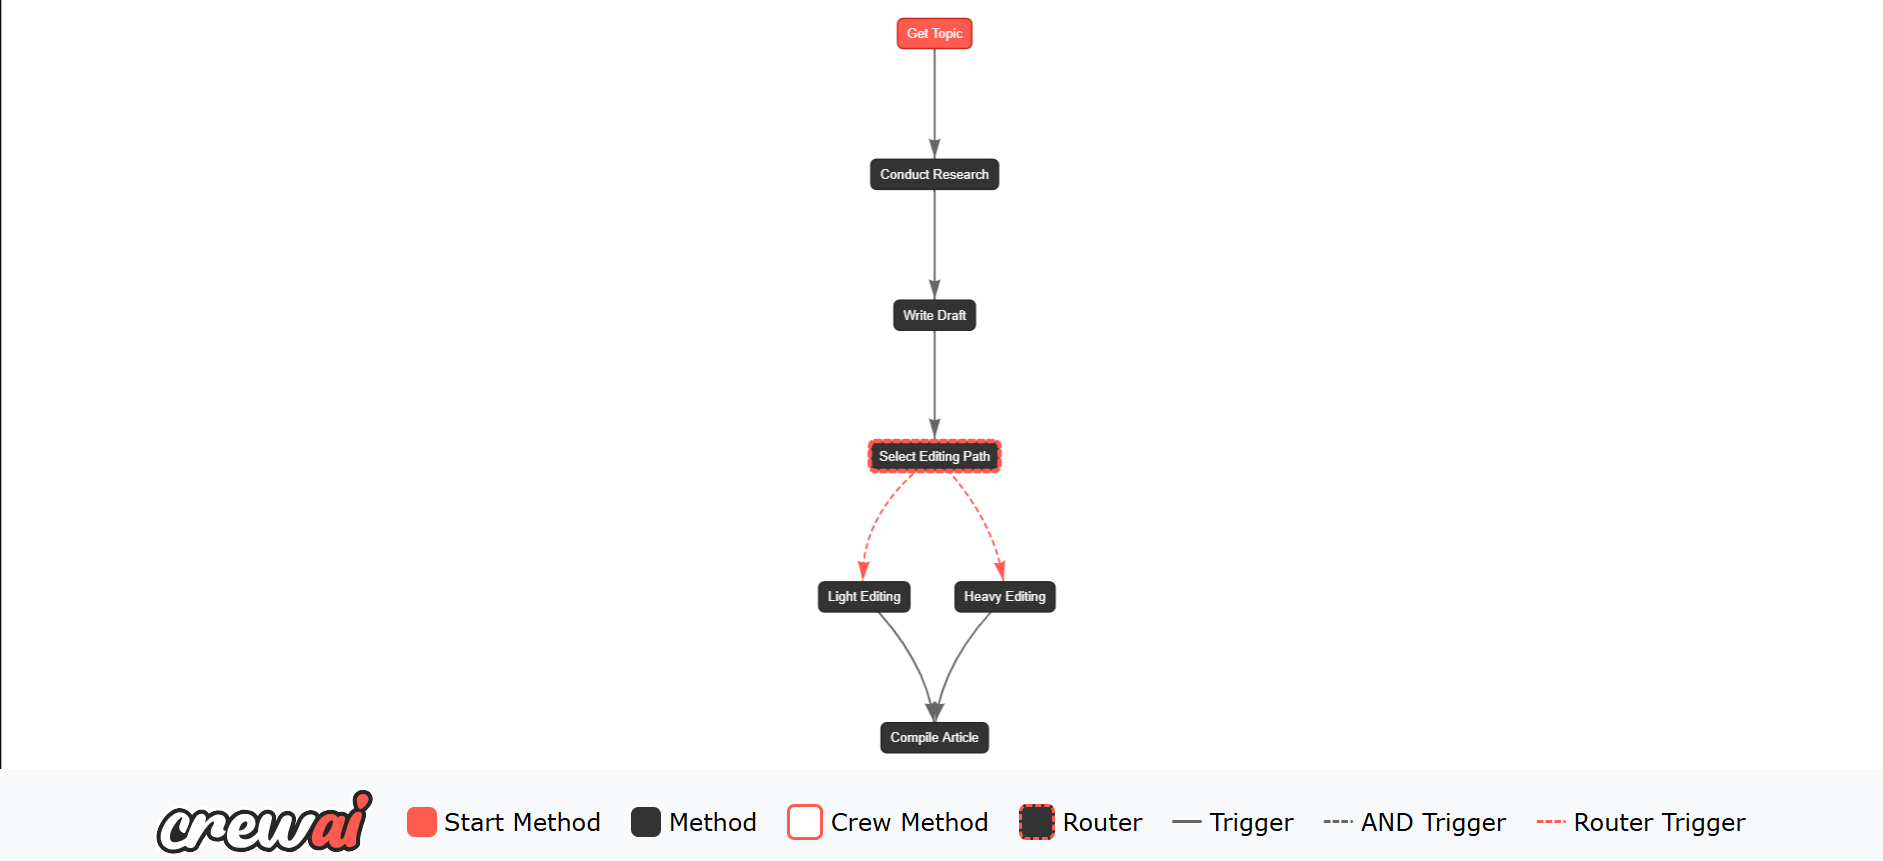

In [31]:
import nest_asyncio
nest_asyncio.apply()

result = flow.kickoff()

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
└── 🧠 Starting Flow...

 Flow started with ID: 573831bf-836a-4f33-9cc5-900c9f4203f9


🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── 🧠 Starting Flow...
└── 🔄 Running: get_topic

Topic selected: AI in Healthcare


🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
└── ✅ Completed: get_topic

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
└── 🔄 Running: conduct_research

Research completed: ## AI in Healthcare: A Brief Research Summary

Artificial Intelligence (AI) is rapidly transforming healthcare, offering potential to improve efficiency, accuracy, and patient outcomes. Research in this field is booming, focusing on various applications:

**Key Areas of Application:**

*   **Diagnosis & Treatment:** AI algorithms, particularly deep learning models, are used to analyze medical images (X-rays, MRIs) for early disease detection (e.g., cancer, cardiovascular disease), predict patient risk, and personalize treatment plans.
*   **Drug Discovery & Development:** AI accelerates the drug development process by identifying potential drug candidates, predicting drug efficacy, and optimizing clinical trial design, reducing costs and time.
*   **Robotics & Surgery:** AI-powered robots assist surgeons with complex procedures, enhancing precision, minimizing invasiveness, and improving patient recovery.
*   **Patient Monitoring & Management:** AI-enabled wearable 

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
└── ✅ Completed: conduct_research

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
└── 🔄 Running: write_draft

Draft written: ## The AI Revolution in Healthcare: Transforming Care and Shaping the Future

Artificial Intelligence (AI) is no longer a futuristic concept; it's rapidly becoming a transformative force in healthcare, promising to reshape how we diagnose, treat, and manage patient care. From sophisticated diagnostic tools to robotic surgical assistants, AI is poised to revolutionize the industry, offering the potential for improved efficiency, accuracy, and ultimately, better patient outcomes. This article provides a comprehensive overview of the current state of AI in healthcare, exploring its key applications, research trends, challenges, and future prospects.

**Key Areas of Application: A Spectrum of Innovation**

The impact of AI is being felt across a wide spectrum of healthcare applications:

*   **Diagnosis & Treatment:** Perhaps the most prominent application, AI algorithms, particularly those based on deep learning, are proving remarkably adept at analyzing medical images. Thi

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
└── ✅ Completed: write_draft

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
└── 🔄 Running: select_editing_path

Draft quality score: 52, assigned quality: low


🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
└── ✅ Completed: select_editing_path

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
├── ✅ Completed: select_editing_path
└── 🔄 Running: heavy_editing

Heavy editing applied: ## The AI Revolution in Healthcare: Transforming Care and Shaping the Future

Artificial intelligence (AI) is rapidly transforming healthcare, moving beyond futuristic concepts to become a powerful force reshaping how we diagnose, treat, and manage patient care. From sophisticated diagnostic tools to robotic surgical assistants, AI promises to revolutionize the industry, offering the potential for improved efficiency, accuracy, and, ultimately, better patient outcomes. This article provides a comprehensive overview of the current state of AI in healthcare, exploring its key applications, research trends, challenges, and future prospects.

**I. Key Applications: A Spectrum of Innovation**

AI's impact is being felt across a wide spectrum of healthcare applications, each offering unique opportunities to improve patient care and streamline processes:

*   **A. Diagnosis and Treatment:** Perhaps the most prominent application, AI algorithms, particularly those based 

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
├── ✅ Completed: select_editing_path
└── ✅ Completed: heavy_editing

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
├── ✅ Completed: select_editing_path
├── ✅ Completed: heavy_editing
└── 🔄 Running: compile_article

Article compiled: Final article: ## The AI Revolution in Healthcare: Transforming Care and Shaping the Future

Artificial intelligence (AI) is rapidly transforming healthcare, moving beyond futuristic concepts to become a powerful force reshaping how we diagnose, treat, and manage patient care. From sophisticated diagnostic tools to robotic surgical assistants, AI promises to revolutionize the industry, offering the potential for improved efficiency, accuracy, and, ultimately, better patient outcomes. This article provides a comprehensive overview of the current state of AI in healthcare, exploring its key applications, research trends, challenges, and future prospects.

**I. Key Applications: A Spectrum of Innovation**

AI's impact is being felt across a wide spectrum of healthcare applications, each offering unique opportunities to improve patient care and streamline processes:

*   **A. Diagnosis and Treatment:** Perhaps the most prominent application, AI algorithms, particularly th

🌊 Flow: ComplexContentFlow
    ID: 573831bf-836a-4f33-9cc5-900c9f4203f9
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
├── ✅ Completed: select_editing_path
├── ✅ Completed: heavy_editing
└── ✅ Completed: compile_article

✅ Flow Finished: ComplexContentFlow
├── Flow Method Step
├── ✅ Completed: get_topic
├── ✅ Completed: conduct_research
├── ✅ Completed: write_draft
├── ✅ Completed: select_editing_path
├── ✅ Completed: heavy_editing
└── ✅ Completed: compile_article